# Prescription-based prediction

In [1]:
__author__ = 'Nick Dingwall, Chris Potts, and Devini Senaratna'

__Tl;DR__ This post introduces a new dataset for making predictions about doctors based on their prescribing behavior. We identify some relevant patterns in the data and present baseline supervised learning results, including a quick look at deep classifiers implemented in [TensorFlow](https://www.tensorflow.org). We're releasing all our data and code to encourage others to work on this novel healthcare challenge.

0. [CMS Prescriptions and the Roam Health Knowledge Graph](#CMS-Prescriptions-and-the-Roam-Health-Knowledge-Graph)
0. [The Roam prescribing-behavior dataset](#The-Roam-prescribing-behavior-dataset)
0. [The target variables and their relationships](#The-target-variables-and-their-relationships)
  0. [The gender variable](#The-gender-variable)
  0. [The region variable](#The-region-variable)
  0. [The specialty variable](#The-specialty-variable)
  0. [Relationships between target variables](#Relationships-between-target-variables)
0. [Evaluation with macro F1 scores](#Evaluation-with-macro-F1-scores)
0. [Cross-validation and hyperparameter setting](#Cross-validation-and-hyperparameter-setting)
0. [The importance of hyperparameter optimization](#The-importance-of-hyperparameter-optimization)
0. [Some baseline results](#Some-baseline-results)
0. [Feature analysis](#Feature-analysis)
0. [Where is this predictive value coming from?](#Where-is-this-predictive-value-coming-from?)
0. [Deep classifiers](#Deep-classifiers)

## CMS Prescriptions and the Roam Health Knowledge Graph

In 2015, the U.S. Centers for Medicare and Medicaid Services (CMS) publicly released [a dataset of prescriptions made under Medicare Part D in 2013](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Part-D-Prescriber.html). This __CMS Prescriptions__ dataset is a remarkable resource. For each provider, it contains all the drugs they prescribed more than 10 times in that year (based on Medicare Part D claims), along with a lot of other data about those prescriptions (number of beneficiaries, total costs, etc.). 

__What can this record of prescriptions teach us about the nature of healthcare?__ We expect a doctor's prescribing behavior to be governed by many complex, interacting factors related to her specialty, the place she works, her personal preferences, and so forth. How much of this information is hidden away in the Medicare Part D database?

These intuitions suggest a straightforward machine learning set-up: we represent each provider by her vector of prescription counts for all the drugs in the database and see what kinds of predictions those representations will support. Such high-dimensional, sparse representations are common in machine learning, but the source in this case is unusual.

To jump-start research in this area, we extracted an experimental dataset from the Roam Health Knowledge Graph. The Graph makes it easy to combine information from the CMS Prescriptions dataset with other healthcare information. For this dataset, we combined the prescribing behavior with a variety of attributes about doctors: specialty, region, gender, years practicing, location type, and percentage of brand (vs. generic) prescriptions.

This post looks at the degree to which we can learn to predict these variables from the prescription-based representations alone using supervised classifiers. It's our hope that these results serve as solid baselines for trying out new approaches.

To keep this post to a manageable length, we look closely at just a subset of the variables in our dataset, and we evaluate just a few models: maximum entropy, random forest, and feed-forward neural network classifiers. The associated experimental code, [prescription_based_prediction.py](prescription_based_prediction.py), makes it easy to try out other variables and models. Let us know what you find!

In [2]:
from prescription_based_prediction import *

In [3]:
# Needed only for embedding images for portability:
from IPython.display import SVG, display

## The Roam prescribing-behavior dataset

The dataset is [available here in JSONL format](https://drive.google.com/a/roaminsight.com/file/d/0B74q78UGE393VGQ4WjBPcXhkN1k/view?usp=sharing) (one JSON record per line, each representing a single provider). The following puts the dataset into a format suitable for training and assessing supervised models.

In [4]:
X, ys, vectorizer = build_experimental_dataset(
    drug_mincount=50, specialty_mincount=50)

`X` is the matrix of predictors: each row corresponds to a provider's vector of prescription counts, which have been [TF-IDF transformed](https://en.wikipedia.org/wiki/Tf–idf) to help bring out contrasts and to help overcome the challenges of the [approximately Zipfian](https://colala.bcs.rochester.edu/papers/piantadosi2014zipfs.pdf) distribution of the prescription counts.

`ys` is a pandas DataFrame aligned row-wise with `X` giving the available target variables. And `vectorizer` is an [sklearn.feature_extraction.DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) that holds the feature names (corresponding to columns of `X`). It can also be useful for featurizing new examples.

As the keyword arguments suggest, `build_experimental_dataset` does two noteworthy things to the dataset beyond formatting it for machine learning. First, it limits attention to just providers who prescribed at least 50 distinct drugs, to avoid trying to reason about providers for whom we have almost no evidence. Second, it restricts attention to providers whose specialty has at least 50 occurrences in the data; there are 282 specialties in all, the majority of which occur fewer than 10 times &ndash; not enough evidence for sensible prediction.

## The target variables and their relationships

The dataFrame `ys` includes seven target variables:

In [5]:
ys.head()

,brand_name_rx_count,gender,generic_rx_count,region,settlement_type,specialty,years_practicing
0,384,M,2287,South,non-urban,Nephrology,7
1,316,M,1035,West,non-urban,Nephrology,6
2,374,M,2452,Northeast,urban,Gastroenterology,5
3,683,M,3462,Midwest,urban,Psychiatry,7
4,143,M,2300,Northeast,urban,Psychiatry,7


We'll set __years_practicing__ aside &ndash; it seems better treated as a continuous variable, and the framework here is geared towards classification (though an extension to regression would require only a handful of changes). (Note: these values are derived from the National Provider Index. Since NPI numbers were assigned in 2008 and the CMS data are from 2013, the value 8 is really "8 or more".)

The variables __brand_name_rx_count__ and __generic_rx_count__ probably aren't useful on their own, but some combination of them (say, as a ratio) might yield insights. 

Anyway, we'll focus on the three simple classification problems represented by __gender__, __region__, and __specialty__. The lessons we learn here should serve us well on additional problems too.

In [6]:
%matplotlib inline

### The gender variable

The gender variable skews __male__ (though there is a relationship with __years practicing__ &ndash; see below):

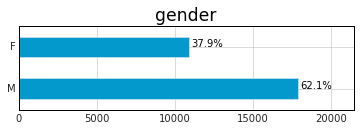

In [7]:
_ = target_barplot(ys['gender'], figsize=(6,1.5))

### The region variable

This distribution is a initially surprising. Relative to [the US population as a whole](http://www2.census.gov/geo/pdfs/maps-data/maps/thematic/us_popdensity_2010map.pdf), the South is over-represented.

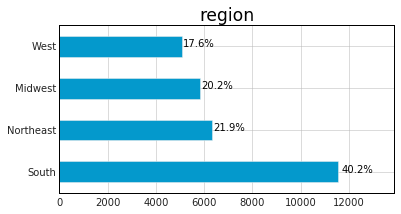

In [8]:
_ = target_barplot(ys['region'], figsize=(6,3))

This likely traces to a systematic bias in the CMS dataset: it's a record of Medicare payments and hence mostly records data on older patients, who are [over-represented in the South, especially in Florida](http://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf). This is a useful reminder that we're studying _Medicare_ prescriptions, a very large but very particular subset of all the prescriptions written in the US.

### The specialty variable

There are 29 specialties in our experimental dataset. The smallest ones have around 55 providers, and the largest, __Cardiovascular Disease__, has 5,311, accounting for 18.5% of the data.

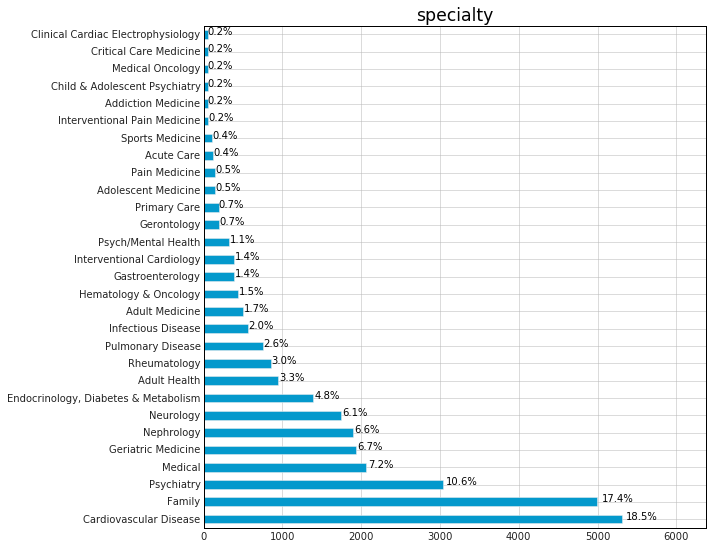

In [9]:
_ = target_barplot(ys['specialty'], figsize=(9,9))

### Relationships between target variables

In addition to the raw distribution of each variable, we should also ask about how they relate to each other. This is an issue we'll return to below. To prefigure that discussion, here's a picture of the relationship between the __gender__ and __specialty__ variables for the seven largest specialties in the dataset:

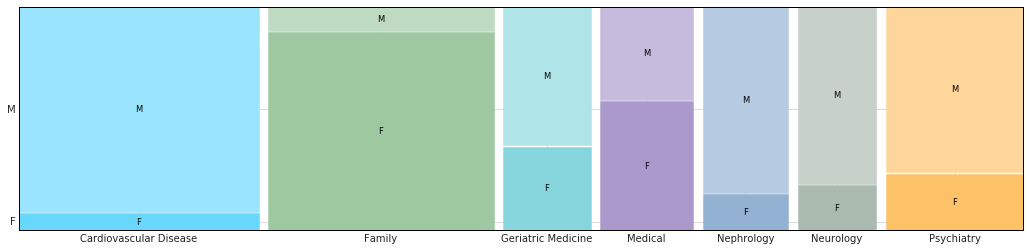

In [10]:
specialty_mosaic(ys, cat2='gender')

It looks like there are strong correlations between these two variables. The correlation seems even stronger for medium-sized specialties:

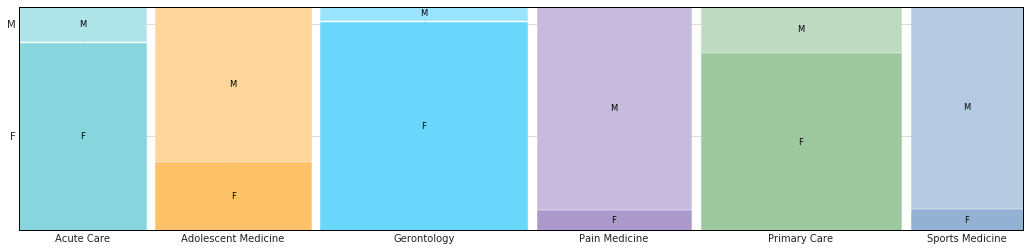

In [11]:
specialty_mosaic(
    ys, cat2='gender', 
    specialty_mincount=100, specialty_maxcount=300)

In light of this, we expect model performance for these two variables to be related.

You can use the function `target_mosaic` to study other relationships. For instance, `target_mosaic(ys['gender'], ys['region'])` gives a gender-by-region mosaic plot (which shows no strong relationship). 

The __specialty__ variable has a lot of levels, so it's a bit unwieldy, but `specialty_mosaic` helps with limiting to specific subsets, and you can use the `cat2` keyword argument for other variables. For instance, `specialty_mosaic(ys, cat2='region')`, which mostly shows that the specialties are distributed in accord with the overall region sizes, though there might be subtle patterns to be found. 

In contrast, there is a strong relationship between __gender__ and __years_practicing__, which adds nuance to the overall gender distribution given above. Doctors just a few years into their practices tend to be women:

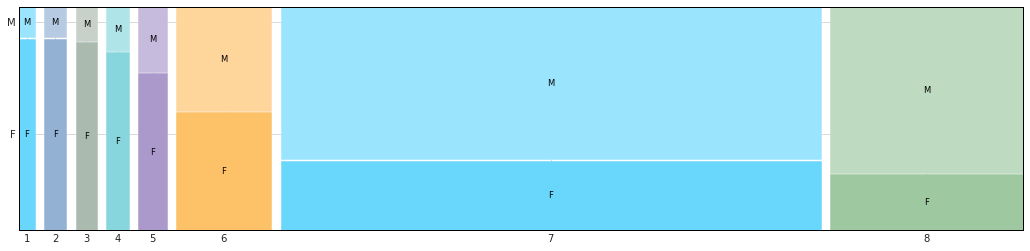

In [12]:
target_mosaic(ys['gender'], ys['years_practicing'])

## Evaluation with macro F1 scores

For this post, we rely on __macro F1 scores__ for evaluating model performance. The F1 score for a given class $C$ balances the model's ability to identify instances of $C$ (recall) with its ability to avoid incorrect predictions for $C$ (precision). The "macro" part is that we simply average the F1 scores for each class to arrive at the final summary, implicitly treating each class as equally important (irrespective of its size).

## Cross-validation and hyperparameter setting

The heart of the experimental framework in `prescription_based_prediction.py` is a function called `cross_validate`. As the name suggests, this function evaluates a given model via cross-validation, a standard experimental set-up where there is no pre-defined partition of the available data into train, development, and test sets. 

More concretely, in 3-fold cross-validation, the available examples are divided into 3 disjoint sections, and then 3 separate evaluations are run:

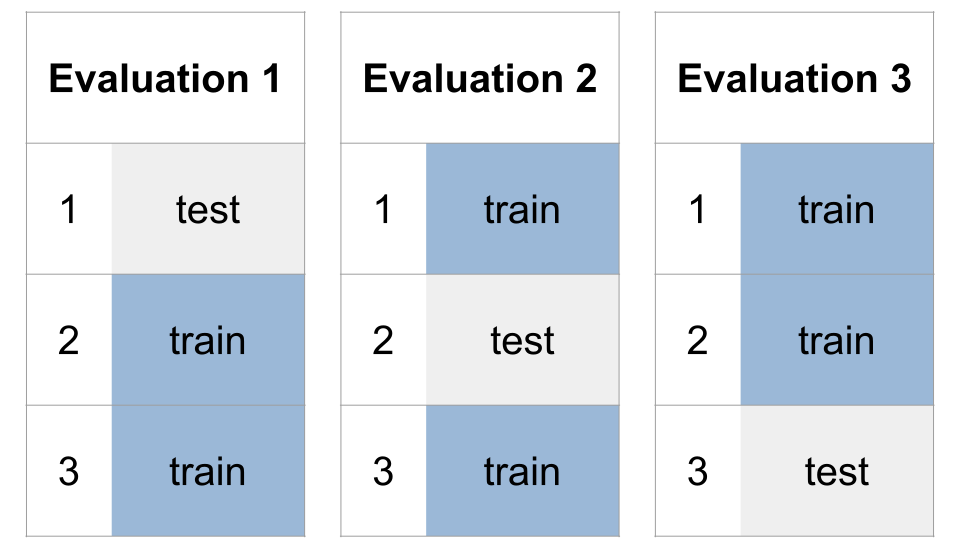

In [13]:
display(SVG("fig/crossvalidation.svg"))

By default `cross_validate` does 5-fold cross-validation. But it does more! For each evaluation, the training examples are used to try to find the optimal setting of the model's hyperparameters. This involves a separate cross-validation:

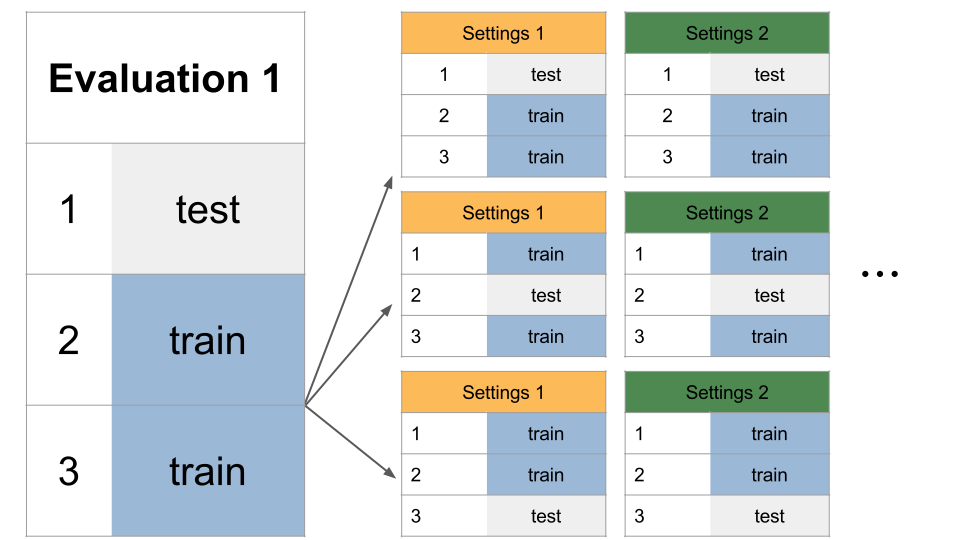

In [14]:
display(SVG("fig/hyperparameter-setting.svg"))

For each setting of the hyperparameters, a cross-validation run is performed __inside__ the training data. The setting with the best performance on average is then used for the actual evaluation on the originally held out test set. The process is repeated for each of the cross-validation evaluations. Intuitively, we're trying to ensure that each evaluation puts the model in the best possible light.

## The importance of hyperparameter optimization

The above experimental setting involves fitting _lots_ of models. Is it worth it? 

Here's an example use of `cross_validate` with a simple [maximum entropy](http://nlp.stanford.edu/pubs/maxent-tutorial-slides.pdf) (multiclass logistic regression) classifier:

In [15]:
from sklearn.linear_model import LogisticRegression

scores_region, region_best_models = cross_validate(
    X, ys['region'].values, 
    LogisticRegression(
        solver='lbfgs', multi_class='multinomial'),
    param_grid={'C': np.logspace(-2.0, 3, 10)})

Fold 1 score 0.698; best params: {'C': 21.544346900318846}
Fold 2 score 0.698; best params: {'C': 5.9948425031894086}
Fold 3 score 0.707; best params: {'C': 77.426368268112782}
Fold 4 score 0.699; best params: {'C': 1000.0}
Fold 5 score 0.703; best params: {'C': 1000.0}


In [16]:
summarize_crossvalidation(scores_region)

'Mean F1: 0.70; 95% confidence interval: 0.6966-0.7057'

All of the parameters of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) are fixed except for the value of the inverse regularization strength `C`. The ideal value for `C` is found by an exhaustive search over the values given in `param_grid`, which go from 0.0001 to 100 in regular log-scale increments. Again, for each evaluation, the best value for `C` is found separately and used for that evaluation. 

For logistic regression, regularization can make a significant difference. For instance, if we fix the value of `C` to be 0.25 (low given the values chosen above), then performance drops by  4%, corresponding to about 1,200 more incorrect predictions:

In [17]:
scores_region_fixedC, region_fixedC_best_models = cross_validate(
    X, ys['region'].values, 
    LogisticRegression(
        C=0.25, solver='lbfgs', multi_class='multinomial'),
    param_grid={})

Fold 1 score 0.660; best params: {}
Fold 2 score 0.659; best params: {}
Fold 3 score 0.666; best params: {}
Fold 4 score 0.656; best params: {}
Fold 5 score 0.667; best params: {}


In [18]:
summarize_crossvalidation(scores_region_fixedC)

'Mean F1: 0.66; 95% confidence interval: 0.6565-0.6665'

## Some baseline results

The framework in [prescription_based_prediction.py](prescription_based_prediction.py) includes a convenience function `run_all_experiments` that does a cross-validation run for a specified subset of the target variables and accumulates the results into a summary dict. This makes it easy to gather together a tabular summary of how various models are doing. For this post, we study just __gender__, __region__, and __specialty__.

To set a baseline for our baselines, we first evaluate a [DummyClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes guesses proportional to the underlying label distribution &ndash; i.e., it treats the class (intercept) features as the only ones:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_summary = run_all_experiments(X, ys,
    DummyClassifier(strategy='stratified'))

For a more robust baseline, we use the maximum entropy classifier defined above for all of the targets, again searching just over values for the L2 strength: `C`:

In [ ]:
from sklearn.linear_model import LogisticRegression

maxent_summary = run_all_experiments(X, ys,
    LogisticRegression(
        solver='lbfgs', multi_class='multinomial'),
    param_grid={'C': np.logspace(-2.0, 3, 10)})

The maximum entropy model makes a strong assumption of linearity. In essence, the conditional probability of a label given an input feature representation is assumed to be a _linear_ function of that input representation. As such, it's not capable of modeling interactions among the dimensions of those representations. We had a hunch that such interactions might exist in our prescription-based features. To test this, we also evaluate a [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). Here, the hyperparameters we explore concern the size and shape of the trees in the forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_summary = run_all_experiments(X, ys,
    RandomForestClassifier(
        n_jobs=5, class_weight='balanced'),
    param_grid={'max_depth':[100,500,1000,1500,2000], 
                'max_features': ['sqrt', 'log2']})

The function `prep_summaries` reformats and combines summaries like `dummy_summary`,  `maxent_summary`, and `forest_summary` into a single table that can serve as the overall summary of what happened in the experiments:

In [22]:
overall_summary = prepare_summaries(
    (dummy_summary, maxent_summary, forest_summary), 
    include_cis=False) # True to include confidence intervals.

overall_summary.round(2)

,target,n_classes,DummyClassifier,LogisticRegression,RandomForestClassifier
0,gender,2,0.50,0.77,0.73
1,region,4,0.25,0.70,0.50
2,specialty,29,0.04,0.45,0.37


These results are unambiguous. The __DummyClassifier__ sets up a lower-bound on performance. The __LogisticRegression__ and __RandomForestClassifier__ models beat this by very wide margins for all three targets __y__. This shows that the prescription-based representations encode a lot of information about all three of these variables. 

It's a surprise that the __LogisticRegression__ is so much better than the __RandomForestClassifier__. We expected the __RandomForestClassifier__ to do at least as well; why this performance difference exists remains an open question.

## Feature analysis

Having found some successful models, we naturally want to understand _how_ they make their predictions, since this could lead us to deeper insights about the domain &mdash; in this case, about the rich story that prescribing behaviors tell about the practice of healthcare.

For models like `LogisticRegression`, one common heuristic is to inspect the learned weights for each feature&ndash;class pair. The highest weighted features for each class are likely to indicate strong positive associations with that class, and conversely for the most negative.  This can be a reliable guide if the faeture values are normalized first (otherwise it can be quite misleading). In the following, we employ this heuristic by averaging the weights learned by each of the `LogisticRegression` models chosen above in the task of __specialty__ prediction:

In [23]:
# Get the summary for the 'specialty problem':
target_summary = next(d for d in maxent_summary 
                      if d['target']=='specialty')

# Average and organize the weights; `vectorizer` comes 
# from `build_experimental_dataset` above.
specialty_weight_summary = inspect_regression_weights(
    target_summary['models'], 
    vectorizer)

Here, we look at just three prominent specialities as a check:

In [24]:
pd.concat((specialty_weight_summary[s] 
           for s in ['Cardiovascular Disease',
                     'Endocrinology, Diabetes & Metabolism',
                     'Psychiatry']), axis=1).head().round(2)

,Cardiovascular Disease,Weight,"Endocrinology, Diabetes & Metabolism",Weight,Psychiatry,Weight
0,NADOLOL,7.79,METHIMAZOLE,9.74,NORTRIPTYLINE HCL,6.46
1,NITROSTAT,6.44,INSULIN SYRINGE,7.48,SUBOXONE,6.00
2,CLOPIDOGREL,6.23,HYDROCORTISONE,7.40,VIIBRYD,5.56
3,DIGOX,6.23,LEVOTHYROXINE SODIUM,6.92,TRIFLUOPERAZINE HCL,4.79
4,FELODIPINE ER,6.07,FORTEO,6.83,QUETIAPINE FUMARATE,4.05


These associations make a lot of sense. For instance, Nadolol is for high blood pressure, Methimazole is an antithyroid, and Nortriptyline is an antidepressant. Feel free to check out other specialties using the above command.

However, there are drawbacks to the above method. For instance, logistic regression weights are notoriously hard to interpret in the presence of correlated features, because the weights get distributed among those features, masking their true value. Conversely, very sparse but highly discriminating features can get large weights, creating the misleading impression that they have significant practical value. Normalizing the feature values mitigates this issue somewhat, but it can still cause trouble.

In addition, this method is particular to regression models, which isn't in the spirit of the wide-ranging approach to modeling we took above. 

What we'd really like is a method that is model-independent and more grounded in practical importance. __Permutation feature importance__ is such a method. In permutation feature importance, a model is fit on the actual feature representations and evaluated on a test set _T_ to obtain a score _S_. Then, for each feature _F_, the values for _F_ in _T_ are randomly permuted, and the score _S'_ of the model on that perturbed version of _T_ is compared to _S_. The difference between _S_ and _S'_ estimates the importance of _F_. This method is mainly applied to decision tree models, but it is appropriate for any kind of model and any scoring method. 

The main drawback to permutation feature importance in the present context is that it doesn't provide information about how particular features associate with particular weights. In this context, we have been exploring Marco Tulio Ribeiro's new package [LIME](https://github.com/marcotcr/lime), which [debuted as a system demonstration at NAACL 2016](http://aclweb.org/anthology/N/N16/N16-3020.pdf)
(Ribeiro, Singh, and Guestrin). LIME (Local Interpretable Model-agnostic Explanations) offers a model-independent assessment method that also summarizes the relationships between features and classes. This is potentially just what we're looking for! In addition, it has spiffy graphics right out of the box. 

LIME inspects individual examples, rather than entire models, but sampling around in these focused assessments can lead to insights about the whole system. The function `lime_inspection` will randomly sample an example with the target label provided and runs LIME's `LimeTabularExplainer` on it, based on one of the models in the summary provided. Here we inspect a __Psychiatry__ example:

In [25]:
lime_inspection(
    X, ys, vectorizer, maxent_summary, 
    target='specialty', label='Psychiatry',
    num_features=5, top_labels=1)

As with our weights-based inspection, this summary makes sense (and is typical of what we've seen from LIME). All of the top positive features are drugs typically prescribed by psychiatrists, and, for this particular doctor, they even begin to outline subspecialties.

## Where is this predictive value coming from?

In our overview of the dataset, we briefly looked at the [relationships between our target variables](#Relationships-between-target-variables). The investigation showed clearly that there is a strong correlation between specialty and gender in our data. This suggests an explanation for why we are able to do so well at predicting gender based on prescriptions: it's not that prescribing behaviors differ by gender (which would be hard to make sense of intuitively), but rather that prescribing behaviors differ by specialty (very intuitive), and specialties differ by gender. To begin to test this intuition, we can see how well __specialty__ predicts __gender__ using the same modeling framework as above:

In [27]:
# One-hot encoded matrix of specialties:
X_specialties = pd.get_dummies(ys['specialty']).values

specialty2gender, specialty2gender_models = cross_validate(
    X_specialties, 
    ys['gender'].values, 
    LogisticRegression(
        solver='lbfgs', multi_class='multinomial'),
    param_grid={'C': np.logspace(-2.0, 3.0, 10)})

Fold 1 score 0.780; best params: {'C': 1.6681005372000592}
Fold 2 score 0.810; best params: {'C': 0.035938136638046278}
Fold 3 score 0.792; best params: {'C': 0.035938136638046278}
Fold 4 score 0.790; best params: {'C': 0.035938136638046278}
Fold 5 score 0.799; best params: {'C': 0.035938136638046278}


In [28]:
summarize_crossvalidation(specialty2gender)

'Mean F1: 0.79; 95% confidence interval: 0.7817-0.8067'

This is remarkably strong predictive value, in line with [our initial visualizations](#Relationships-between-target-variables). This suggests that prescribing behavior doesn't predict __gender__ per se, but rather that prescribing behavior predicts __specialty__, which is correlated with __gender__.

The same technique can be used to study the relationships between other pairs of target variables. Together with mosaic plots like the ones above, this can start to yield a rich picture of the real-world influences that underlie the supervised learning results.

## Deep classifiers

We had a hunch that there would be important interactions among the dimensions of our feature representations, which led us to try out a random forest classifier. That experiment didn't support our hunch, but we might still be correct empirically. In this day and age, in situations like this, it's hard to resist trying out a neural network to see whether it can [find patterns that other models can't](http://www.nature.com/nature/journal/v521/n7553/full/nature14539.html). 

To this end, we added to `prescription_based_prediction` a neural network class called `DeepClassifier` written in [TensorFlow](https://www.tensorflow.org). It has two hidden layers of representation and lets you fiddle with (or, better, cross-validate) the hidden layer dimensionalities, the [drop-out rates](http://jmlr.org/papers/v15/srivastava14a.html), and the internal activation functions. The graph for the model looks like this, with the variable names matched to those used in the code:

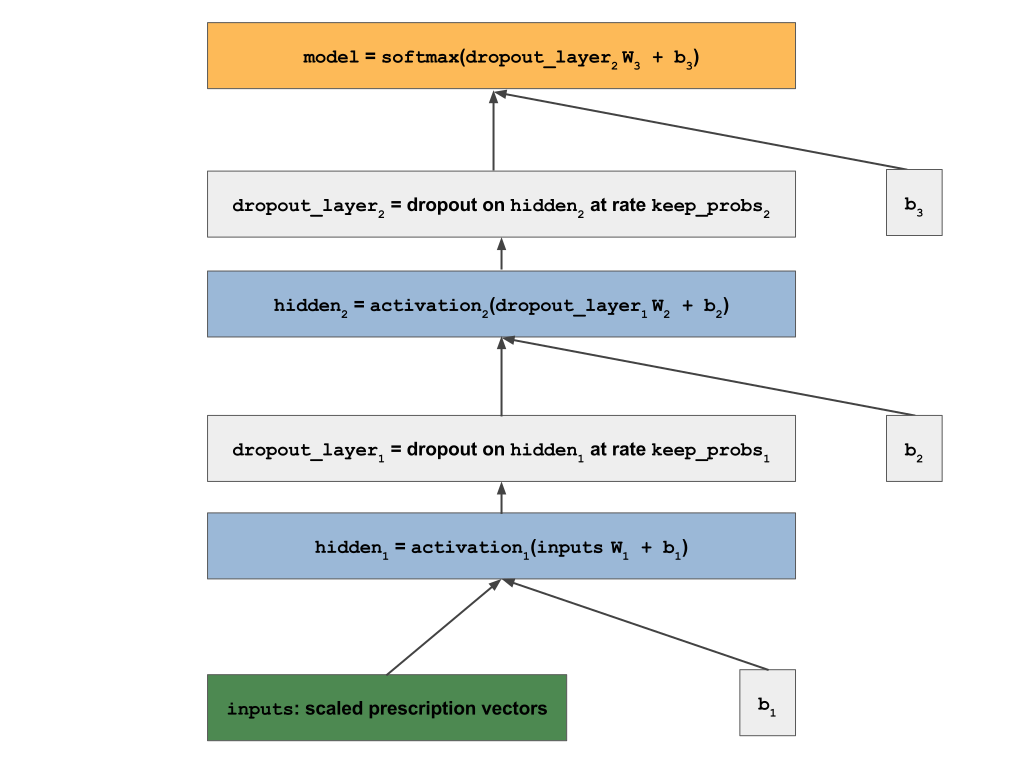

In [29]:
display(SVG("fig/nn-graph.svg"))

The `DeepClassifier` class has the right set of methods to mimic a scikit-learn model, at least as far as the current code is concerned. Thus, it can be used interchangeably with the models explored above; `cross_validate` and `run_all_experiments` both happily accept it. Here's a simple example:

In [30]:
import tensorflow as tf

nn_summary, _ = cross_validate(
   X.toarray(), 
   ys['gender'].values, 
   DeepClassifier(
       hidden_dim1=50,
       hidden_dim2=50,
       keep_prob1=0.7,
       keep_prob2=0.7,
       activation1=tf.nn.relu,
       activation2=tf.nn.relu,
       verbose=True,
       max_iter=3000,
       eta=0.005),
   param_grid={})

In [31]:
summarize_crossvalidation(nn_summary)

'Mean F1: 0.74; 95% confidence interval: 0.7264-0.7438'

This performance is not competitive with the best models above (recall that `LogisticRegression` achieved 0.77 F1). However, we did not run the models to convergence (`max_iter` is pretty low), and notice that we set all of the hyperparameters by hand (empty `param_grid`). There are a *lot* of hyperparameters for this model, so it's easy to imagine that we made poor choices for the current problem. Unfortunately, a thorough assessment would require a significant expenditure of computational resources. On the brighter side, careful hyperparameter search could help make these experiments _somewhat_ more tractable. <span style='color:red'>Here, we will link to the hyperparameter post.</span>